Montowanie dysku

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! unzip -q '/content/drive/MyDrive/Inżynierka/Dane/train.zip'
! unzip -q '/content/drive/MyDrive/Inżynierka/Dane/test.zip'
! unzip -q '/content/drive/MyDrive/Inżynierka/Dane/dev.zip'

Import paczek

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import torchvision.transforms as tt
from torchvision.datasets import ImageFolder

Import danych

In [ ]:
data_dir = '/content'
print(os.listdir(data_dir))
classes_test = os.listdir(data_dir + "/test")
classes_train = classes_test
print(f'Train Classes - {classes_train}')
print(f'Test Classes - {classes_test}')

['.config', 'drive', 'train', 'dev', 'test', 'sample_data']
Train Classes - ['happiness', 'anger', 'fear', 'disgust', 'sadness', 'surprise', 'neutrality']
Test Classes - ['happiness', 'anger', 'fear', 'disgust', 'sadness', 'surprise', 'neutrality']


In [ ]:
train_tfms = tt.Compose([tt.Resize((64,64)), 
                         tt.Grayscale(num_output_channels=1),
                         tt.RandomHorizontalFlip(),
                         tt.RandomRotation(30),
                         tt.ToTensor()])

valid_tfms = tt.Compose([tt.Resize((64,64)),
                         tt.Grayscale(num_output_channels=1),
                         tt.ToTensor()])

In [ ]:
train_ds = ImageFolder(data_dir + '/train', train_tfms)
valid_ds = ImageFolder(data_dir + '/dev', valid_tfms)

In [ ]:
batch_size = 64

In [ ]:
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)
valid_dl = DataLoader(valid_ds, batch_size*2, num_workers=3, pin_memory=True)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        print(images[0].shape)
        ax.imshow(make_grid(images[:64], nrow=8).permute(1, 2, 0))
        break

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


torch.Size([1, 64, 64])


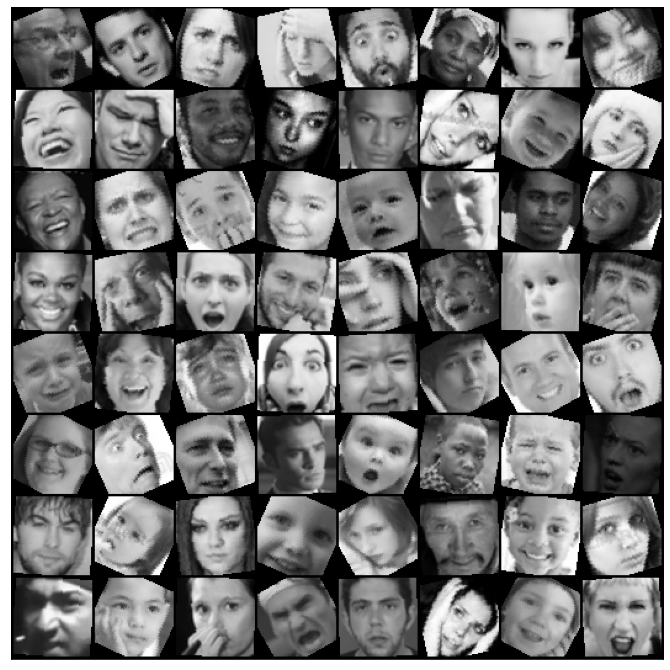

In [ ]:
show_batch(train_dl)

GPU

In [ ]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        return len(self.dl)

In [ ]:
device = get_default_device()
device

device(type='cuda')

In [ ]:
torch.cuda.empty_cache()

In [ ]:
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

Ustawienia treningu

In [ ]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)
        loss = F.cross_entropy(out, labels)
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)
        loss = F.cross_entropy(out, labels)
        acc = accuracy(out, labels)
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))

Model

In [ ]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class ResNet(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        
        self.input = conv_block(in_channels, 64)

        self.conv1 = conv_block(64, 64, pool=True)
        self.res1 = nn.Sequential(conv_block(64, 32), conv_block(32, 64))
        self.drop1 = nn.Dropout(0.5)
        
        self.conv2 = conv_block(64, 64, pool=True)
        self.res2 = nn.Sequential(conv_block(64, 32), conv_block(32, 64))
        self.drop2 = nn.Dropout(0.5)
        
        self.conv3 = conv_block(64, 64, pool=True)
        self.res3 = nn.Sequential(conv_block(64, 32), conv_block(32, 64))
        self.drop3 = nn.Dropout(0.5)
        
        self.classifier = nn.Sequential(nn.MaxPool2d(6), 
                                        nn.Flatten(),
                                        nn.Linear(64, num_classes))
        
    def forward(self, xb):
        out = self.input(xb)

        out = self.conv1(out)
        out = self.res1(out) + out
        out = self.drop1(out)
        
        out = self.conv2(out)
        out = self.res2(out) + out
        out = self.drop2(out)
        
        out = self.conv3(out)
        out = self.res3(out) + out
        out = self.drop3(out)
        
        return self.classifier(out)

In [ ]:
model = to_device(ResNet(1, len(classes_train)), device)
model

ResNet(
  (input): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv1): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )

Trening

In [ ]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader,
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    
    # Set up custom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_loader))
    
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            # Gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()
            
            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()
        
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [ ]:
history = [evaluate(model, valid_dl)]
history

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[{'val_acc': 0.13671875, 'val_loss': 1.9486942291259766}]

In [ ]:
epochs = 40
max_lr = 0.001
grad_clip = 0.2
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [ ]:
%%time
history += fit_one_cycle(epochs, max_lr, model, train_dl, valid_dl, 
                        grad_clip=grad_clip, weight_decay=weight_decay, opt_func=opt_func)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch [0], last_lr: 0.00006, train_loss: 2.3526, val_loss: 1.9864, val_acc: 0.1371
Epoch [1], last_lr: 0.00010, train_loss: 1.8267, val_loss: 1.9537, val_acc: 0.1456
Epoch [2], last_lr: 0.00018, train_loss: 1.7640, val_loss: 1.9204, val_acc: 0.2165
Epoch [3], last_lr: 0.00028, train_loss: 1.6912, val_loss: 1.8568, val_acc: 0.2780
Epoch [4], last_lr: 0.00040, train_loss: 1.5766, val_loss: 1.7351, val_acc: 0.3553
Epoch [5], last_lr: 0.00052, train_loss: 1.4488, val_loss: 1.6338, val_acc: 0.3631
Epoch [6], last_lr: 0.00064, train_loss: 1.3670, val_loss: 1.5198, val_acc: 0.4600
Epoch [7], last_lr: 0.00076, train_loss: 1.3026, val_loss: 1.4202, val_acc: 0.4819
Epoch [8], last_lr: 0.00086, train_loss: 1.2521, val_loss: 1.3992, val_acc: 0.4773
Epoch [9], last_lr: 0.00094, train_loss: 1.2056, val_loss: 1.2451, val_acc: 0.5335
Epoch [10], last_lr: 0.00098, train_loss: 1.1686, val_loss: 1.2722, val_acc: 0.5088
Epoch [11], last_lr: 0.00100, train_loss: 1.1376, val_loss: 1.2615, val_acc: 0.5151
Ep

In [ ]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs')

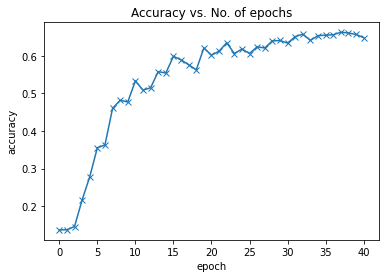

In [ ]:
plot_accuracies(history)

In [ ]:
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.')

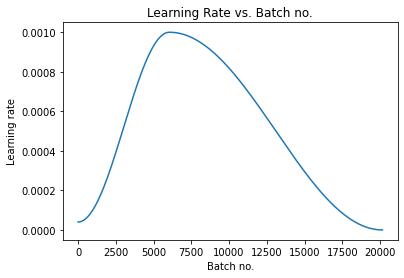

In [ ]:
plot_lrs(history)

In [ ]:
torch.save(model.state_dict(), '/content/drive/MyDrive/Inżynierka/Collab/pytorch/ResNet/ResNet1.pth')

Statystyki modelu

In [ ]:
model = ResNet(1, len(classes_train))

In [ ]:
model.load_state_dict(torch.load('/content/drive/MyDrive/Inżynierka/Collab/pytorch/ResNet/ResNet1.pth', map_location=torch.device('cpu')))

<All keys matched successfully>

In [ ]:
model = to_device(model, device)
model

ResNet(
  (input): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv1): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )

In [ ]:
test_tfms = tt.Compose([tt.Resize((64,64)),
                         tt.Grayscale(num_output_channels=1),
                         tt.ToTensor()])

test_ds = ImageFolder(data_dir + '/test', test_tfms)

test_dl = DataLoader(test_ds, 490, num_workers=1, pin_memory=True)

test_dl = DeviceDataLoader(test_dl, device)

In [ ]:
#evaluate(model, valid_dl)

In [ ]:
#evaluate(model, test_dl)

In [ ]:
from PIL import Image

def predict_image(path):
  img = Image.open(path).convert('RGB')
  preprocess = tt.Compose([tt.Resize((64,64)),
                         tt.Grayscale(num_output_channels=1),
                         tt.ToTensor()])

  img_preprocessed = preprocess(img)
  batch_img_tensor = torch.unsqueeze(img_preprocessed, 0)
  model.eval()
  out = model(batch_img_tensor)
  _, index = torch.max(out, 1)
  return index.item()

In [ ]:
classes = ['anger', 'disgust', 'fear', 'happiness', 'neutrality', 'sadness', 'surprise']

In [ ]:
y_pred = []
y_true = []

data_path = '/content/test'
for c in classes:
  print(c)
  folder_path = os.path.join(data_path, c)
  files = os.listdir(folder_path)
  files.sort()
  for filename in files:
    y_pred.append(predict_image(os.path.join(folder_path,filename)))
    y_true.append(classes.index(c))

anger
disgust
fear
happiness
neutrality
sadness
surprise


In [ ]:
y_pred[270:290]

[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 5, 4, 5, 4, 4, 4, 0, 4, 5]

In [ ]:
y_true[270:290]

[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]

In [ ]:
import sklearn.metrics

In [ ]:
sklearn.metrics.accuracy_score(y_true, y_pred)

0.6265306122448979

In [ ]:
sklearn.metrics.precision_score(y_true, y_pred, average='weighted')

0.7675308018547401

In [ ]:
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder(sparse = False)
one_hot_pred = enc.fit_transform(np.array(y_pred).reshape(-1, 1))

one_hot_true = enc.fit_transform(np.array(y_true).reshape(-1, 1))

In [ ]:
sklearn.metrics.roc_auc_score(one_hot_true, one_hot_pred, average='weighted')

0.7821428571428571

In [ ]:
sklearn.metrics.f1_score(y_true, y_pred, average='weighted')

0.6064979555052792

In [ ]:
sklearn.metrics.confusion_matrix(y_true, y_pred)

array([[60,  0,  0,  0,  2,  8,  0],
       [59,  4,  0,  0,  1,  6,  0],
       [26,  0, 26,  2,  1, 13,  2],
       [ 0,  0,  0, 70,  0,  0,  0],
       [14,  0,  0,  0, 45, 11,  0],
       [14,  0,  0,  0,  4, 52,  0],
       [ 6,  0,  9,  0,  4,  1, 50]])

In [ ]:
#torch.save(model, '/content/drive/MyDrive/Inżynierka/Collab/pytorch/ResNet/ResNet1_mdl_EPOCHS_40.pth')